# Xenium registration (using MERFISH to Visium pipeline)

In [11]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
from matplotlib.lines import Line2D
import os
import glob
import torch

from scipy.stats import rankdata
import time

import imp
import tools
imp.reload(tools)

<module 'tools' from '/Users/jeanfan/Desktop/STalign/tools.py'>

<IPython.core.display.Javascript object>


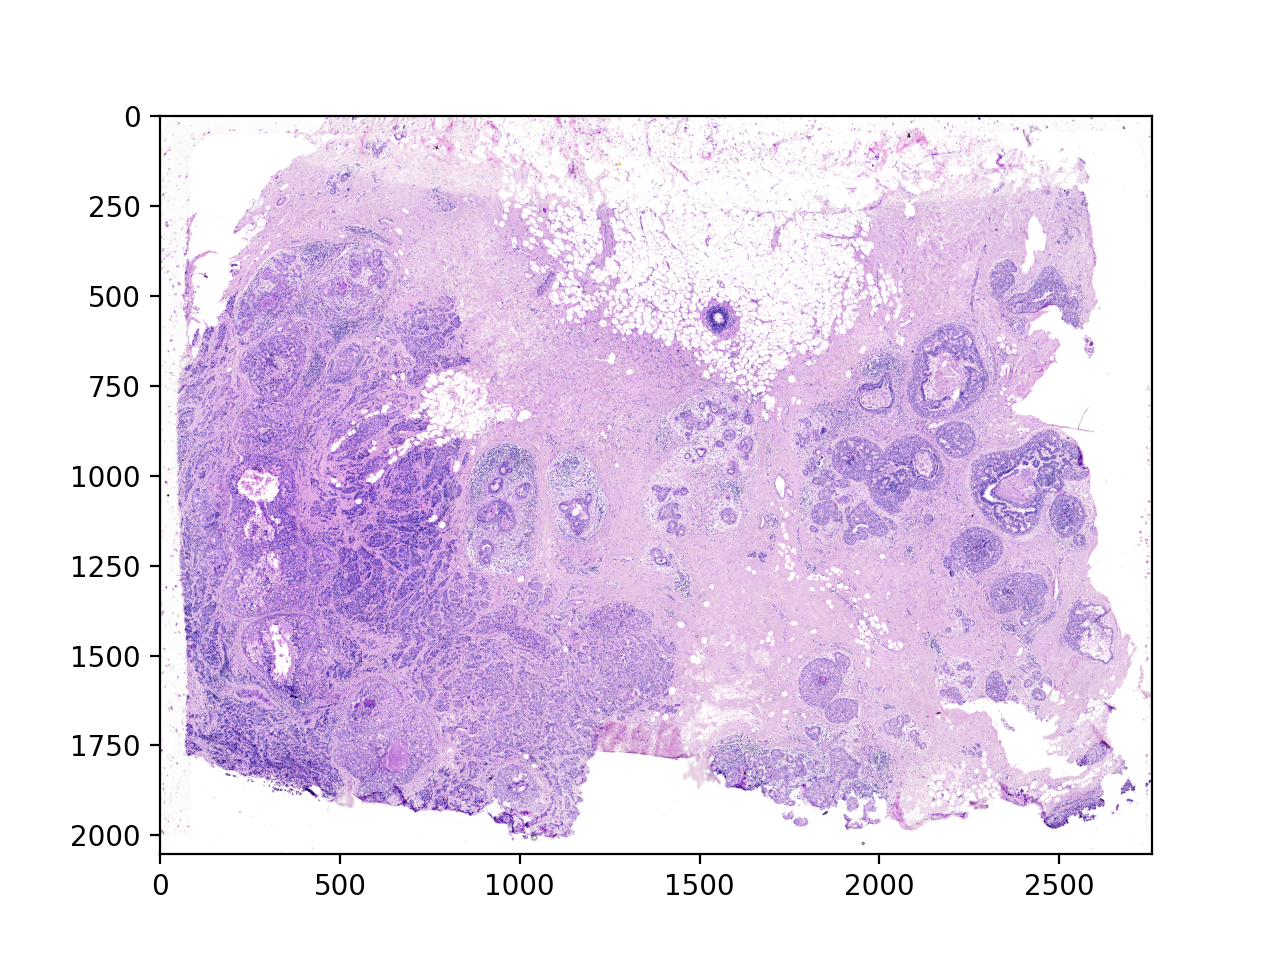

(3, 2051, 2759)

In [19]:
# Target image
visium_file = '/Users/jeanfan/Desktop/STalign/xenium_data/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.png'
V = plt.imread(visium_file)
fig,ax = plt.subplots()
ax.imshow(V)
f.canvas.draw()

V = V.transpose(2,0,1)
V.shape

In [9]:
# Single cell data to be aligned
fname = '/Users/jeanfan/Desktop/STalign/xenium_data/Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv.gz'
df = pd.read_csv(fname)
df.head()

cell_id  x_centroid  y_centroid  transcript_counts  control_probe_counts  \
0        1  377.663005  843.541888                154                     0   
1        2  382.078658  858.944818                 64                     0   
2        3  319.839529  869.196542                 57                     0   
3        4  259.304707  851.797949                120                     0   
4        5  370.576291  865.193024                120                     0   

   control_codeword_counts  total_counts   cell_area  nucleus_area  
0                        0           154  110.361875     45.562656  
1                        0            64   87.919219     24.248906  
2                        0            57   52.561875     23.526406  
3                        0           120   75.230312     35.176719  
4                        0           120  180.218594     34.499375

<IPython.core.display.Javascript object>


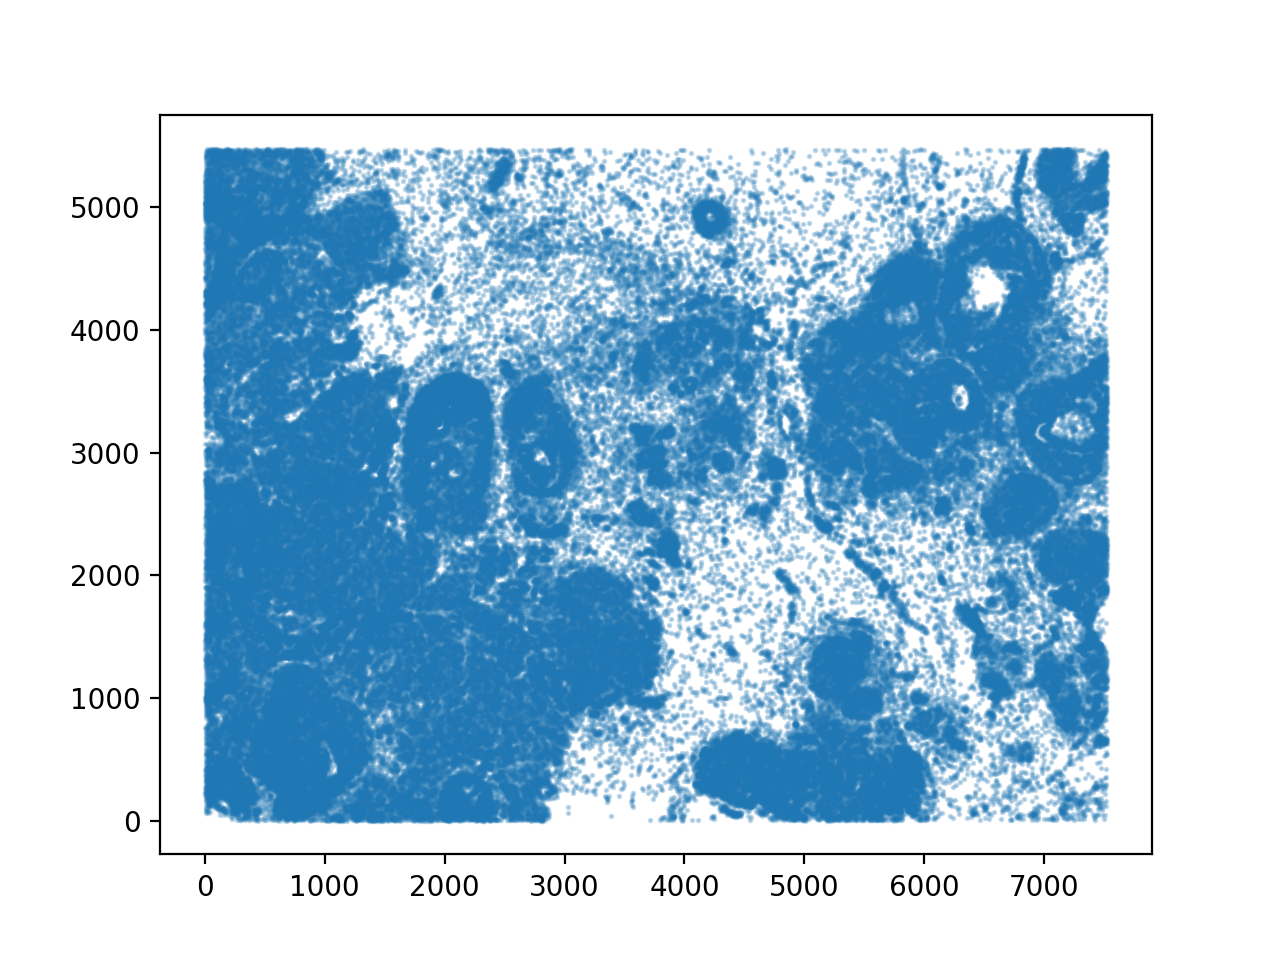

<IPython.core.display.Javascript object>


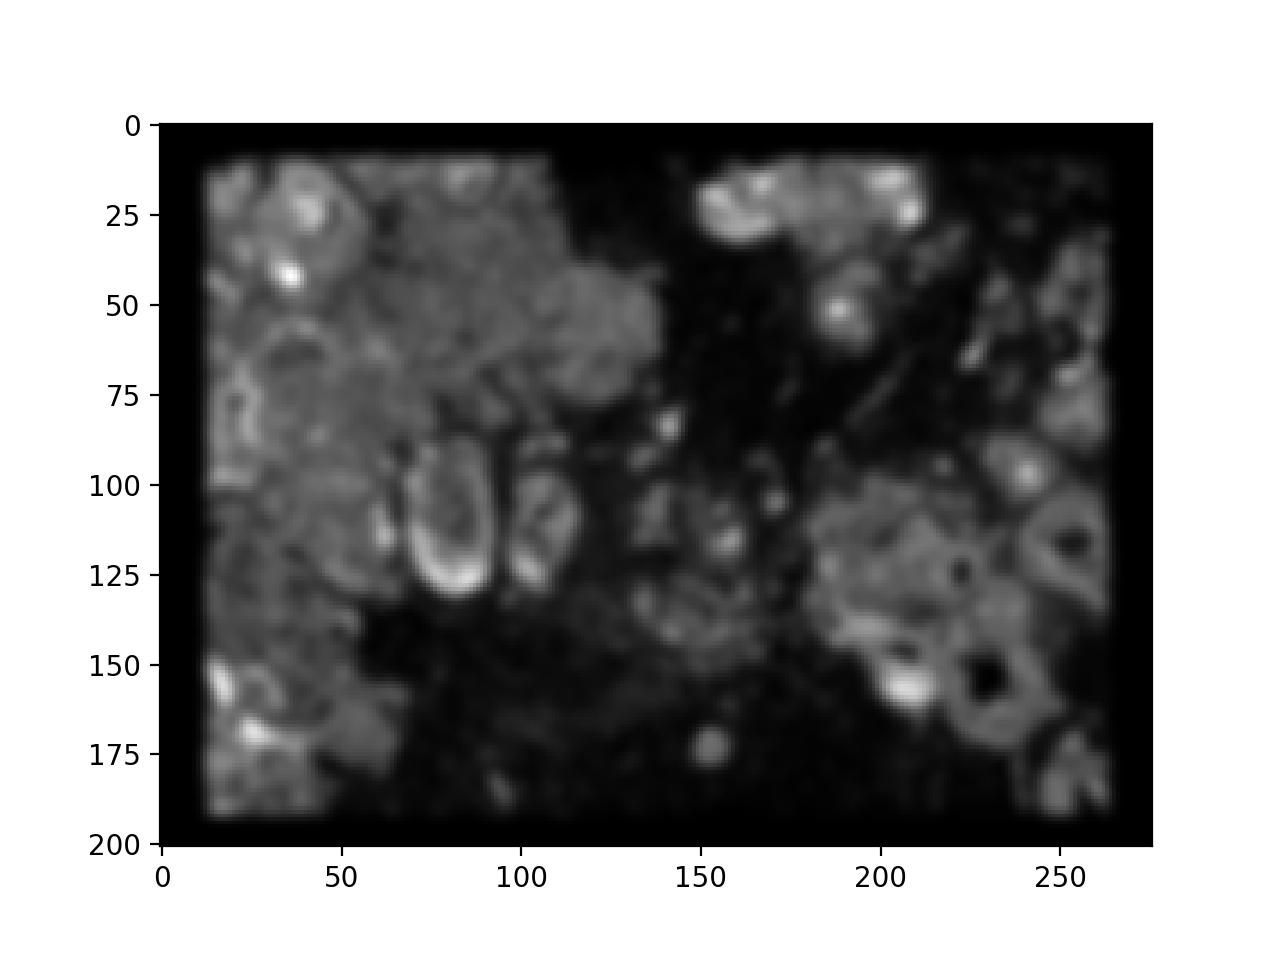

0 of 167782
10000 of 167782
20000 of 167782
30000 of 167782
40000 of 167782
50000 of 167782
60000 of 167782
70000 of 167782
80000 of 167782
90000 of 167782
100000 of 167782
110000 of 167782
120000 of 167782
130000 of 167782
140000 of 167782
150000 of 167782
160000 of 167782
167781 of 167782


(1, 201, 276)

In [55]:
xM = np.array(df['x_centroid'])
yM = np.array(df['y_centroid'])

fig,ax = plt.subplots()
ax.scatter(xM,yM,s=1,alpha=0.25)

X,Y,M,fig = tools.rasterize(xM,yM)
ax = fig.axes[0]
f.canvas.draw()

M.shape

<IPython.core.display.Javascript object>


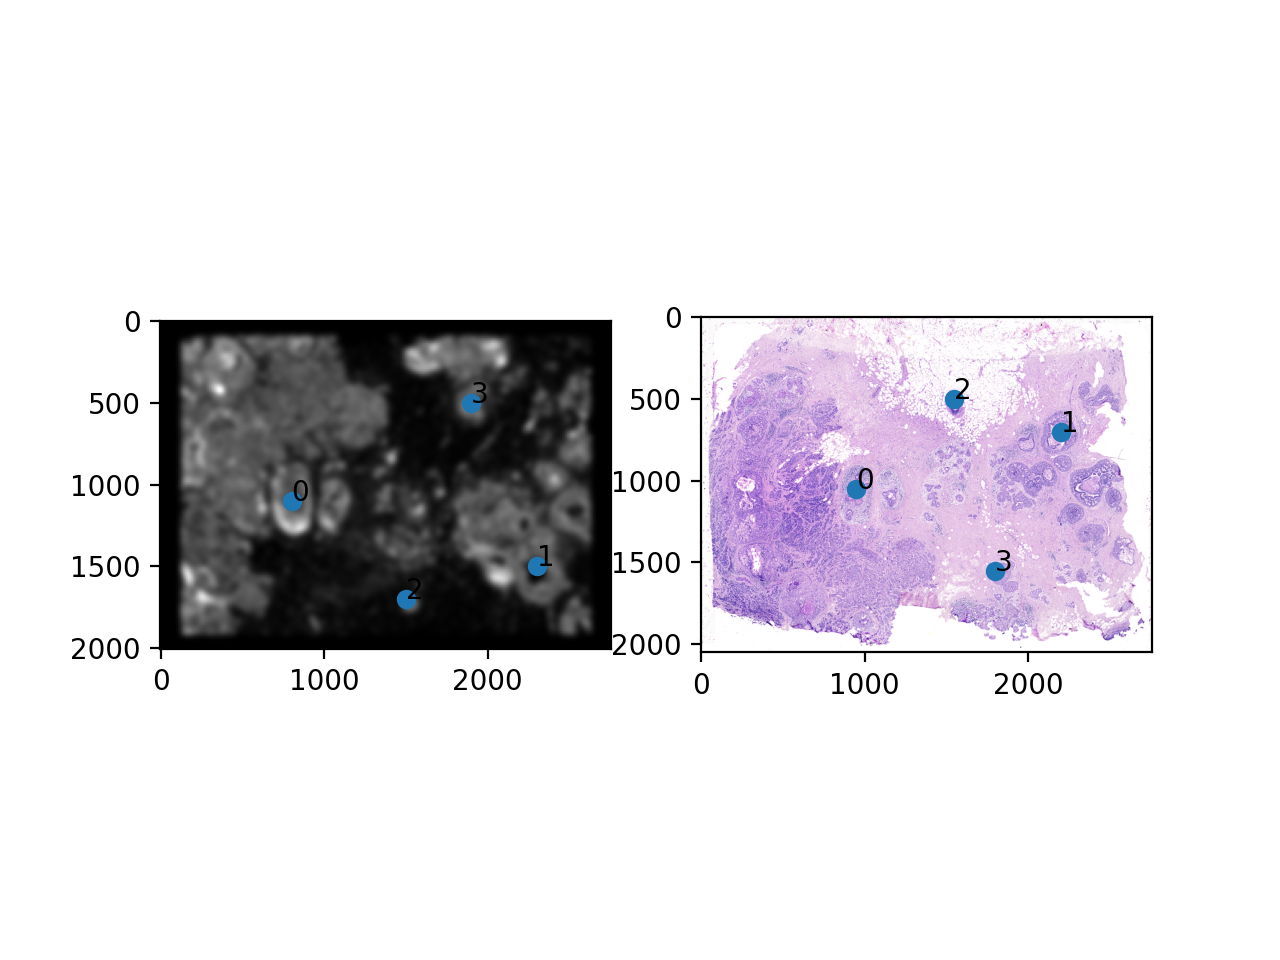

In [108]:
# jean's hack for dealing with imshow error NxMx1 is not valid
foo = np.vstack((M, M, M))
foo.shape

# manually scale to approx same size?
I = tools.normalize(foo)
YI = np.array(range(I.shape[1]))*10.
XI = np.array(range(I.shape[2]))*10.

J = tools.normalize(V).astype(I.dtype)
YJ = np.array(range(J.shape[1]))*1.
XJ = np.array(range(J.shape[2]))*1.

extentI = tools.extent_from_x((YI,XI))
extentJ = tools.extent_from_x((YJ,XJ))

# manually make points
pointsI = np.array([[1100.,800.], [1500., 2300.], [1700., 1500.], [500., 1900.]])
pointsJ = np.array([[1050.,950.], [700., 2200.], [500., 1550.], [1550., 1800.]])

# plot
fig,ax = plt.subplots(1,2)
ax[0].imshow((I/I.max()).transpose(1,2,0).squeeze(), extent=extentI)
ax[1].imshow((J).transpose(1,2,0), extent=extentJ)

ax[0].scatter(pointsI[:,1],pointsI[:,0])
ax[1].scatter(pointsJ[:,1],pointsJ[:,0])
for i in range(pointsI.shape[0]):
    ax[0].text(pointsI[i,1],pointsI[i,0],f'{i}')
    ax[1].text(pointsJ[i,1],pointsJ[i,0],f'{i}')

<IPython.core.display.Javascript object>


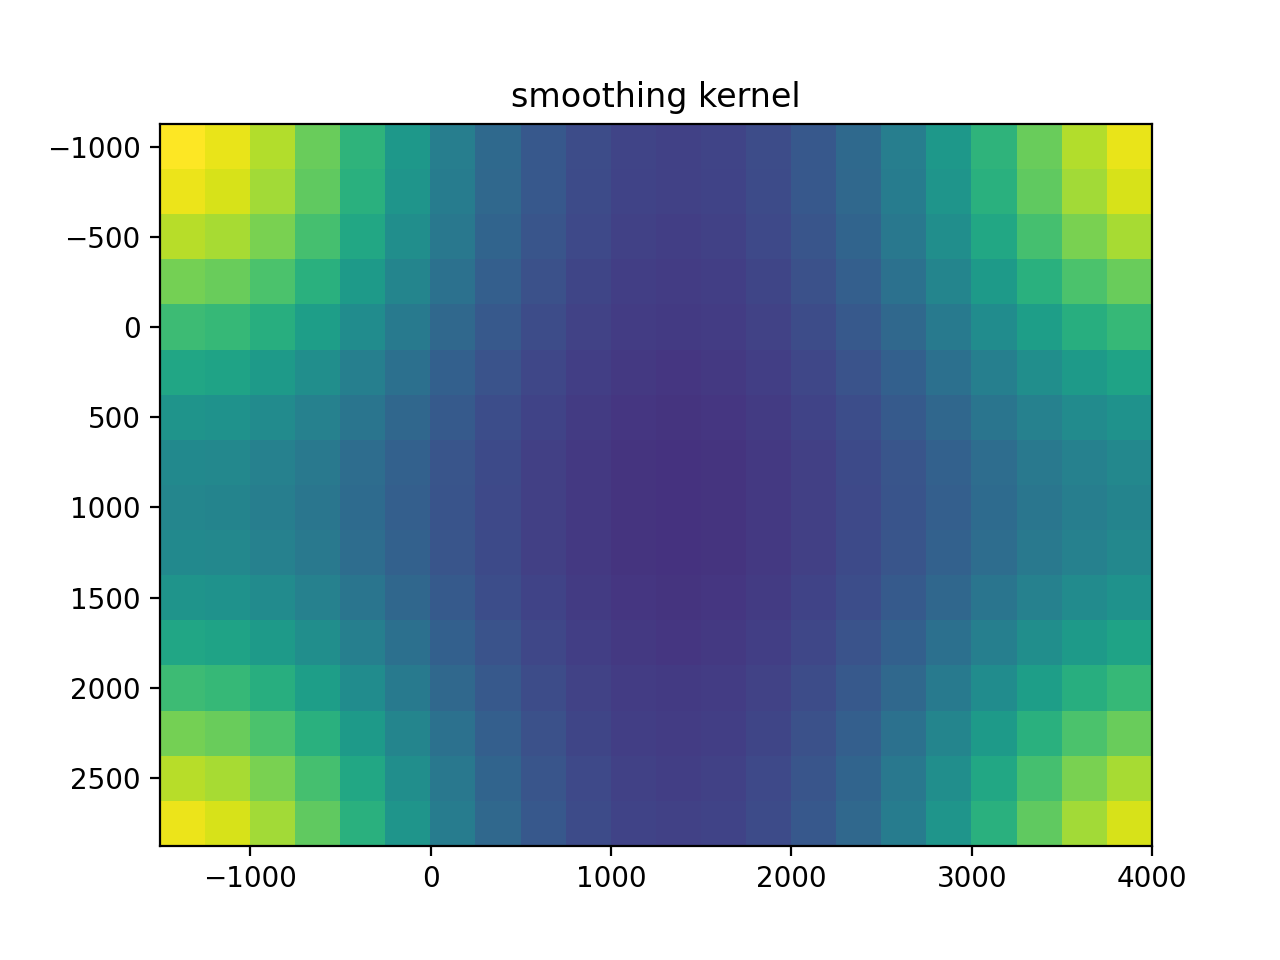

<IPython.core.display.Javascript object>


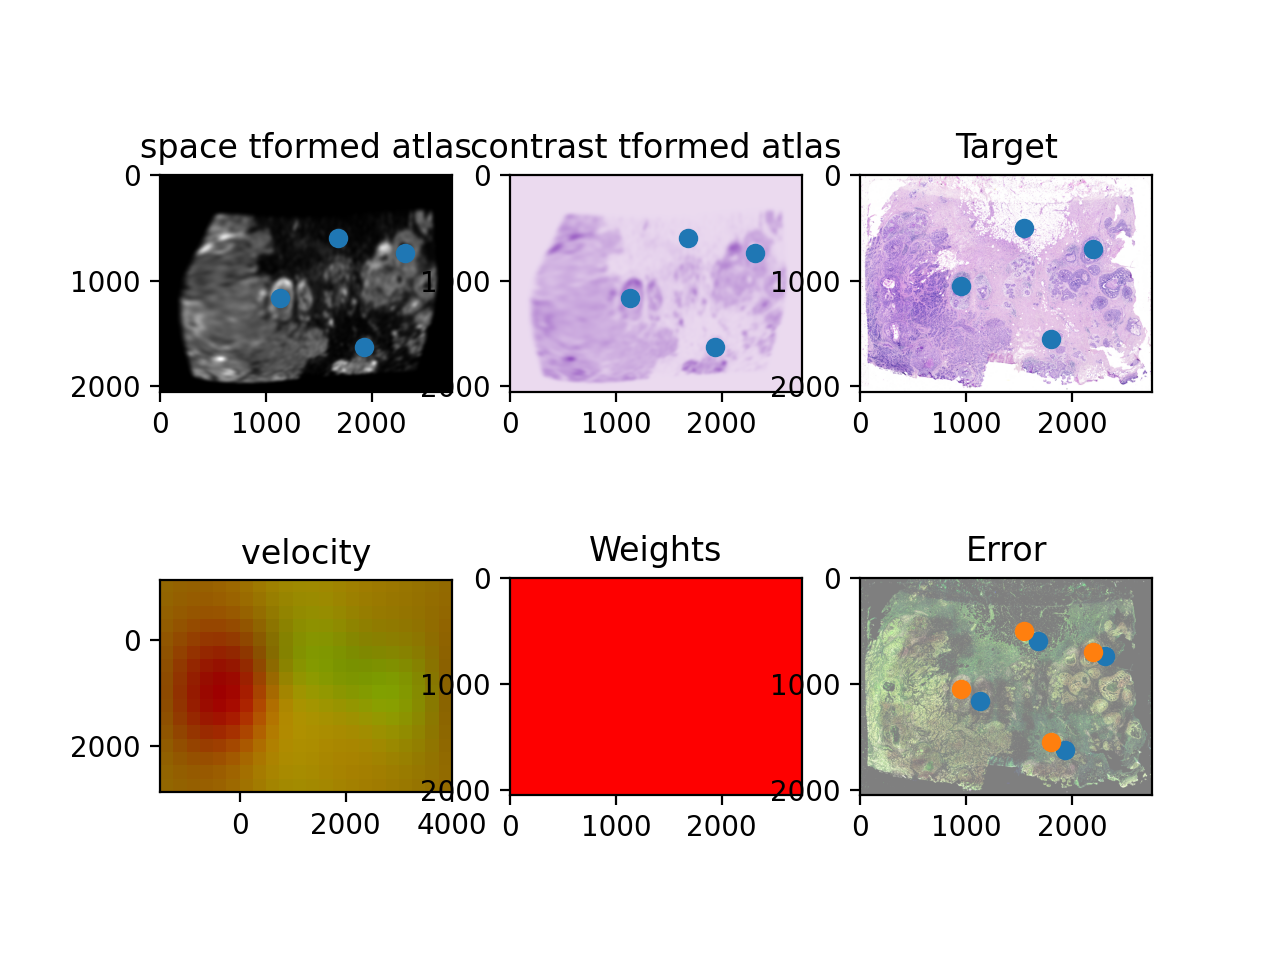

<IPython.core.display.Javascript object>


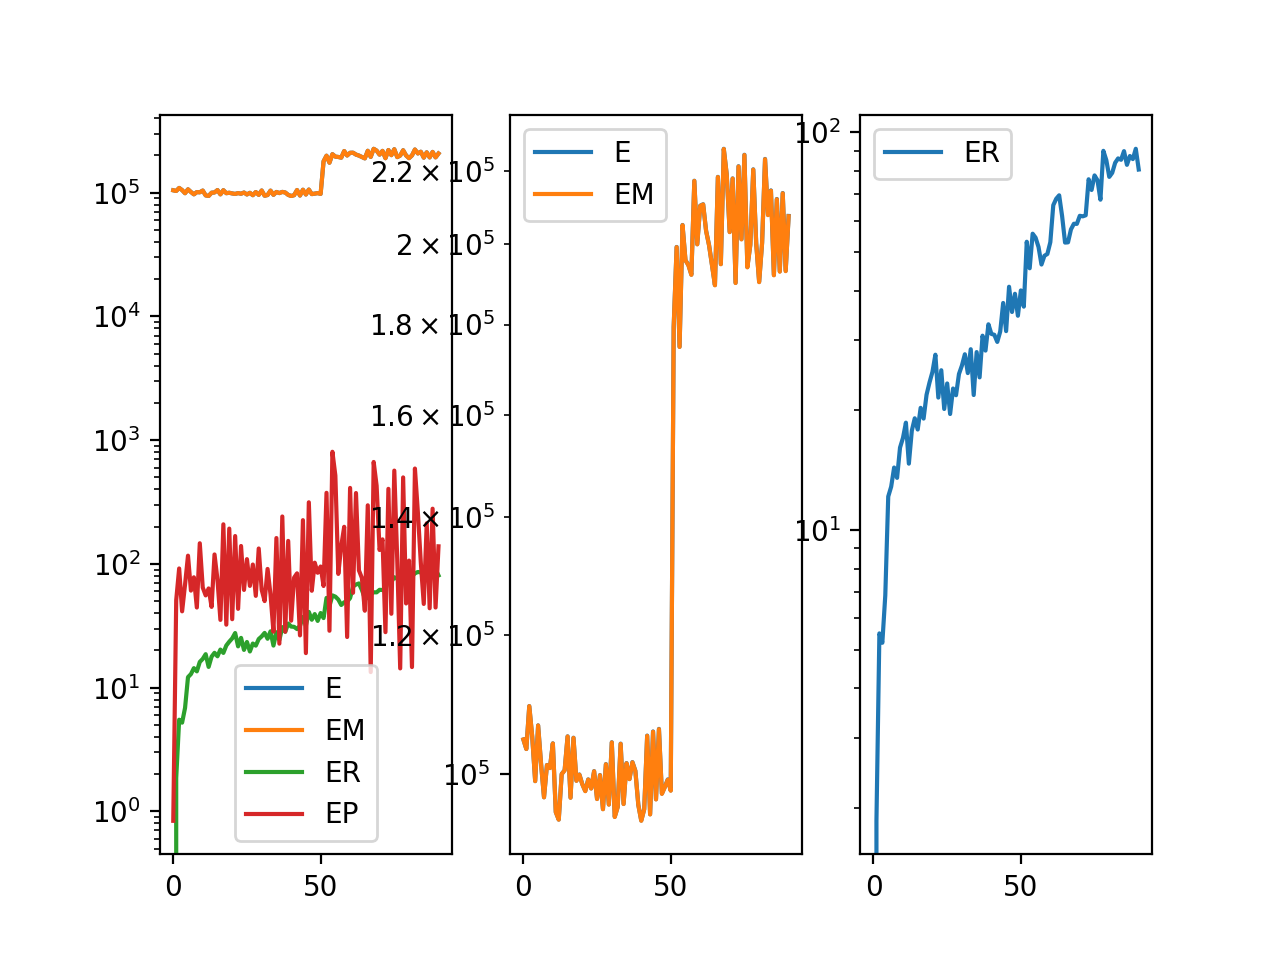

In [109]:
# Alignment 
imp.reload(tools)
L,T = tools.L_T_from_points(pointsI,pointsJ)
device = 'cpu'
params = {'L':L,'T':T,
          'niter':100,
          'pointsI':pointsI,
          'pointsJ':pointsJ,
          'device':device  
          }
A,v,xv = tools.LDDMM([YI,XI],I,[YJ,XJ],J,**params)

# Conclusion: still struggling with setting parameters...
# sometimes parameters lead to error: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
# axE[2].set_yscale('log')

<IPython.core.display.Javascript object>


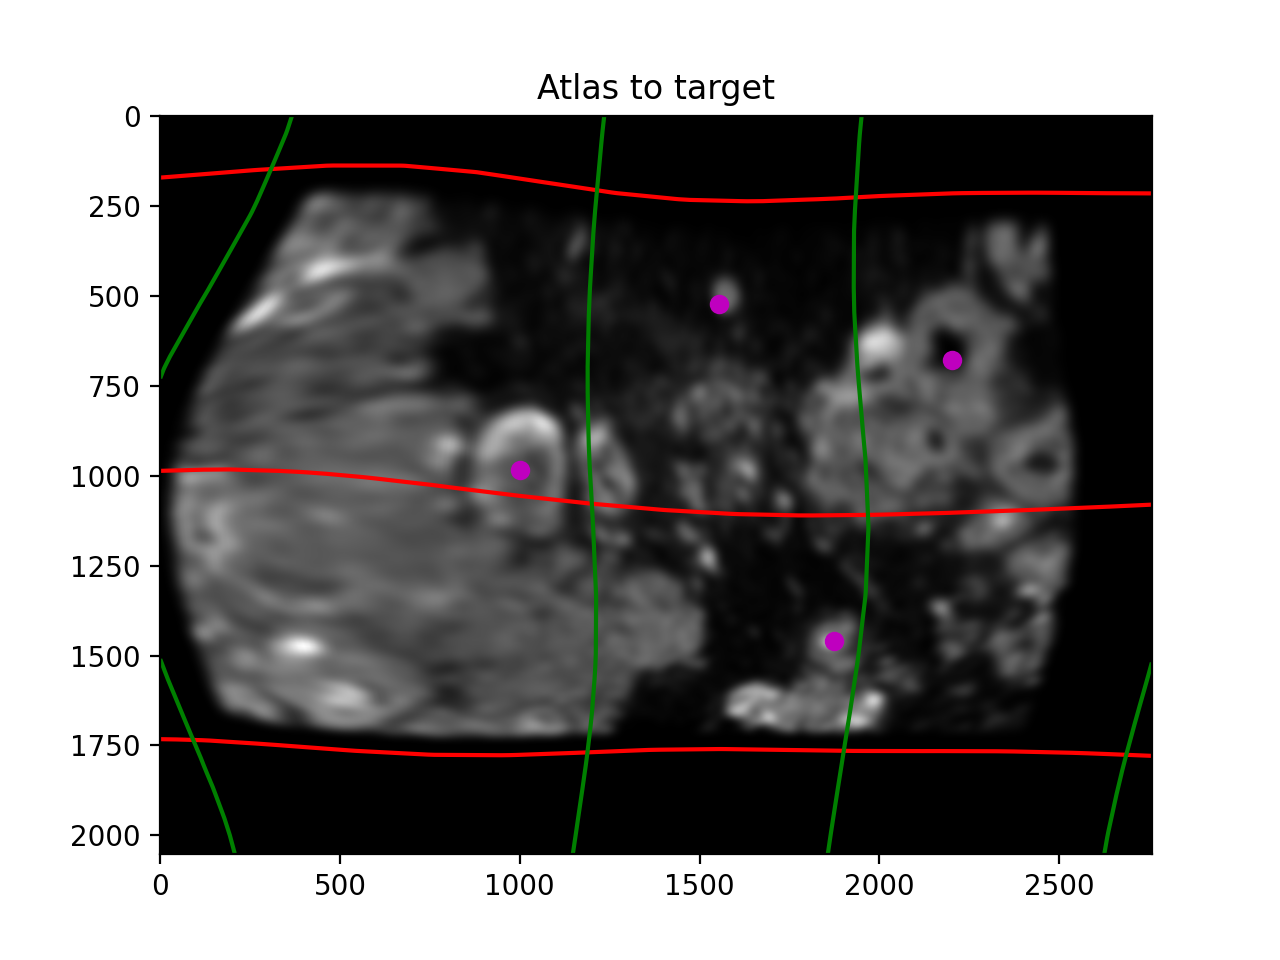

/Users/jeanfan/Desktop/STalign/tools.py:1602: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A)
/Users/jeanfan/Desktop/STalign/tools.py:1603: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.tensor(v)
/Users/jeanfan/Desktop/STalign/tools.py:1615: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  XJ = torch.tensor(XJ)


In [110]:
# now transform the image
imp.reload(tools)
levels = np.arange(-100000,100000,1000)

fig,ax = plt.subplots()
phii = tools.build_transform(xv,v,A,XJ=[YJ,XJ],direction='b')
phiI = tools.transform_image_atlas_to_target(xv,v,A,[YI,XI],I,[YJ,XJ])
phipointsI = tools.transform_points_atlas_to_target(xv,v,A,pointsI)

ax.contour(XJ,YJ,phii[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XJ,YJ,phii[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('Atlas to target')

ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentJ)
ax.scatter(phipointsI[:,1].detach(),phipointsI[:,0].detach(),c="m")

<IPython.core.display.Javascript object>


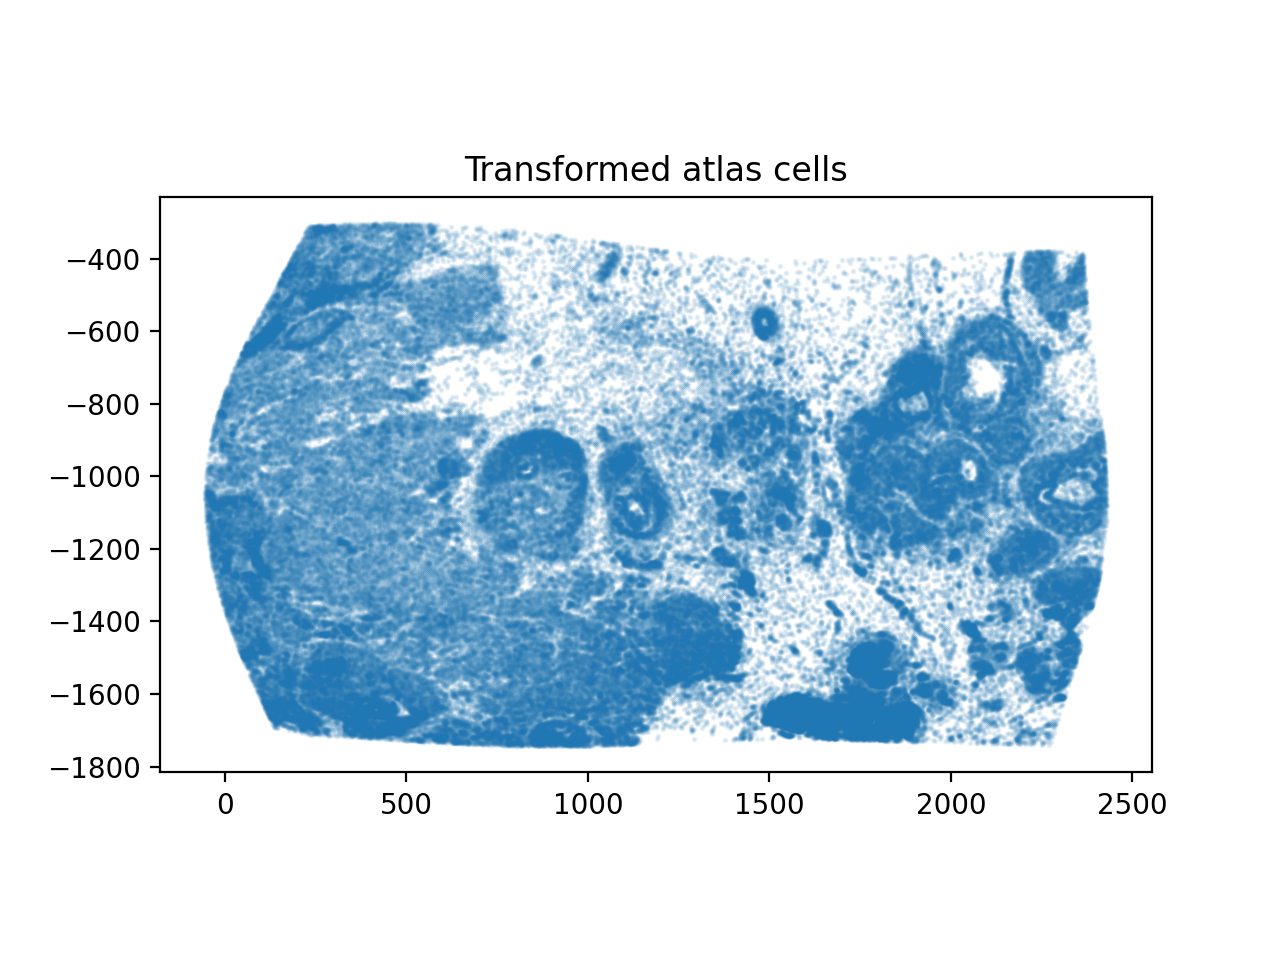

Text(0.5, 1.0, 'Transformed atlas cells')

In [126]:
# Jean: not sure this is right (why do we need to divide original points, why isn't scaling automatic)
pointsIt = tools.transform_points_atlas_to_target(xv,v,A,np.stack([yM/3,xM/3],1))
fig,ax = plt.subplots()
ax.scatter(pointsIt[:,1],-pointsIt[:,0],s=1,alpha=0.1)
ax.set_aspect('equal')
ax.set_title('Transformed atlas cells')

In [47]:
# write out results
#dfout.to_csv('forjean_march10b_2022')
#dfout

Unnamed: 0   fov       volume  \
0      158338042824236264719696604356349910479    33   532.778772   
1      260594727341160372355976405428092853003    33  1004.430016   
2      307643940700812339199503248604719950662    33  1267.183208   
3       30863303465976316429997331474071348973    33  1403.401822   
4      313162718584097621688679244357302162401    33   507.949497   
...                                        ...   ...          ...   
85953  311704042603434891559886168438769992293  1545  1625.490809   
85954  312851880059098327776181257829209599759  1545   905.032435   
85955  332299915869590281339501510603978852698  1545   459.647325   
85956  150462787759670321084458536479486602685  1546   778.386670   
85957  268870416870774615427277589169474700725  1546   592.088115   

          center_x     center_y        min_x        max_x        min_y  \
0       617.916619  2666.520010   614.725219   621.108019  2657.545209   
1       596.808018  2763.450012   589.669218   603.946818  2757.013212   
2       578.880018  2748.978012   570.877217   586.882818  2740.489211   
3       572.616017  2766.690012   564.937217   580.294818  2756.581212   
4       608.364018  2687.418010   603.061218   613.666818  2682.493210   
...            ...          ...          ...          ...          ...   
85953  9623.123579  4030.182069  9615.660779  9630.586379  4019.749269   
85954  9625.067579  4008.749469  9620.088779  9630.046379  4000.320068   
85955  9605.470978  4187.268073  9600.767578  9610.174378  4182.397273   
85956  9606.874978  4208.819338  9600.767578  9612.982378  4200.335938   
85957  9607.841578  4219.019938  9602.700778  9612.982378  4213.393138   

             max_y       rowvis       colvis      Pvis  
0      2675.494810  1421.670436   -33.781665  0.000000  
1      2769.886812  1409.242315   -41.606276  0.000000  
2      2757.466812  1412.233483   -44.178331  0.000000  
3      2776.798812  1410.098527   -46.037109  0.000000  
4      2692.342810  1419.269594   -36.356578  0.000000  
...            ...          ...          ...       ...  
85953  4040.614869  1163.712963  1513.567001  0.459977  
85954  4017.178869  1167.941932  1514.551663  0.465274  
85955  4192.138873  1132.668771  1505.359193  0.483171  
85956  4217.302738  1128.249123  1504.728934  0.480618  
85957  4224.646738  1126.145785  1504.473555  0.468555  

[85958 rows x 12 columns]